이 게시글은 초급자 분들에게 제출 절차만을 설명드리기 위한 코드공유 글입니다.

창의적인 전처리와 EDA를 통해 효율적인 알고리즘을 만들어 주세요

In [261]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
#     print(df)
pd.set_option('display.max_rows', None)

In [301]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, accuracy_score

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold,GroupKFold
from sklearn.metrics import f1_score
import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder
# from lightgbm import LGBMClassifier as lgb

# import optuna.integration.lightgbm as lgb

# from imblearn.over_sampling import SMOTE
SEED = 1996

데이터를 불러옵니다

In [445]:
#경로 설정을 꼭 신경써주세요!!
train=pd.read_csv('train.csv', index_col=0) #인덱스 col=0도 check!
test=pd.read_csv('test_x.csv', index_col=0)
submission=pd.read_csv('sample_submission.csv', index_col=0)  

In [446]:
train = train[train['familysize'] < 35]

In [447]:
train.shape

(45526, 77)

In [430]:
# #log
# log_var = ['QaE','QbE','QcE','QdE','QeE','QfE','QgE','QhE','QiE','QjE','QkE','QlE','QmE','QnE','QoE','QpE','QqE']
# for col in log_var:
#     train[col] = np.log1p(train[col])
# out_lst = []
# for i in ['QaA', 'QaE', 'QbA', 'QbE', 'QcA', 'QcE', 'QdA', 'QdE', 'QeA', 'QeE',
#        'QfA', 'QfE', 'QgA', 'QgE', 'QhA', 'QhE', 'QiA', 'QiE', 'QjA', 'QjE',
#        'QkA', 'QkE', 'QlA', 'QlE', 'QmA', 'QmE', 'QnA', 'QnE', 'QoA', 'QoE',
#        'QpA', 'QpE', 'QqA', 'QqE', 'QrA', 'QrE', 'QsA', 'QsE', 'QtA', 'QtE']:
#     if 'E' in i:
#         out_lst.append(i)
# def detect_outliers(df,features): 
#     outlier_indices = [] 
#     for col in features: 
#         Q1 = np.percentile(df[col], 25) 
#         Q3 = np.percentile(df[col], 75) 
#         IQR = Q3 - Q1 
#         outlier_step = 3 * IQR 
#         outlier_list_col = list(df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index)
        
#         outlier_indices += outlier_list_col
       
#     return outlier_indices
# Outliers_to_drop = detect_outliers(train,out_lst)
# drop = list((set(Outliers_to_drop)))
# train = train.drop(drop)

In [431]:
train.shape

(45532, 77)

In [432]:
train_len = len(train)
test_len = len(test)

In [433]:
all_df = pd.concat([train, test])
all_df.reset_index(inplace = True, drop = True)

In [434]:
all_df['age_group']=(all_df['age_group'].str[-3:-1])
all_df['age_group'] = all_df['age_group'].astype(int)

In [435]:
# #log
# log_var = ['QaE','QbE','QcE','QdE','QeE','QfE','QgE','QhE','QiE','QjE','QkE','QlE','QmE','QnE','QoE','QpE','QqE','QrE','QsE','QtE']
# for col in log_var:
#     del(all_df[col])

In [436]:
#log
log_var = ['QaE','QbE','QcE','QdE','QeE','QfE','QgE','QhE','QiE','QjE','QkE','QlE','QmE','QnE','QoE','QpE','QqE','QrE','QsE','QtE']
for col in log_var:
    all_df[col] = np.log1p(all_df[col])

In [437]:
##마 score
Answers = ['QaA', 'QbA', 'QcA', 'QdA', 'QeA',
             'QfA', 'QgA', 'QhA', 'QiA', 'QjA', 
             'QkA', 'QlA', 'QmA', 'QnA', 'QoA', 
             'QpA', 'QqA', 'QrA', 'QsA', 'QtA']
flipping_columns = ["QeA", "QfA", "QkA", "QqA", "QrA"]
for flip in flipping_columns: 
    all_df[flip] = 6 - all_df[flip]
    flipping_secret_columns = ["QaA", "QdA", "QgA", "QiA", "QnA"]
for flip in flipping_secret_columns: 
    all_df[flip] = 6 - all_df[flip]
all_df['Mach_score'] = all_df[Answers].mean(axis = 1)

In [438]:
#add_nan
all_df.loc[all_df['education'] == 0, 'education'] = np.nan
all_df.loc[all_df['engnat'] ==0, 'engnat'] = np.nan
all_df.loc[all_df['hand'] == 0, 'hand'] = np.nan
all_df.loc[all_df['urban'] == 0, 'urban'] = np.nan
all_df.loc[all_df['married'] == 0, 'married'] = np.nan
all_df.loc[all_df['race'] == 'other', 'race'] = np.nan
all_df.loc[all_df['religion'] == 'other', 'religion'] = np.nan

In [439]:
all_df['wf_03wr_04'] = all_df['wf_03'] + all_df['wr_04']

In [456]:
# all_df['p'] = all_df['religion'].apply(str) + '_' + all_df['race'].apply(str)+ '_' + all_df['engnat'].apply(str)

In [440]:
all_df.columns

Index(['QaA', 'QaE', 'QbA', 'QbE', 'QcA', 'QcE', 'QdA', 'QdE', 'QeA', 'QeE',
       'QfA', 'QfE', 'QgA', 'QgE', 'QhA', 'QhE', 'QiA', 'QiE', 'QjA', 'QjE',
       'QkA', 'QkE', 'QlA', 'QlE', 'QmA', 'QmE', 'QnA', 'QnE', 'QoA', 'QoE',
       'QpA', 'QpE', 'QqA', 'QqE', 'QrA', 'QrE', 'QsA', 'QsE', 'QtA', 'QtE',
       'age_group', 'education', 'engnat', 'familysize', 'gender', 'hand',
       'married', 'race', 'religion', 'tp01', 'tp02', 'tp03', 'tp04', 'tp05',
       'tp06', 'tp07', 'tp08', 'tp09', 'tp10', 'urban', 'voted', 'wf_01',
       'wf_02', 'wf_03', 'wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06',
       'wr_07', 'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13',
       'Mach_score', 'wf_03wr_04'],
      dtype='object')

In [318]:
all_df['10years'] = 0
all_df.loc[all_df['age_group']==10,'10years'] = 1


In [319]:
all_df['age_group'].value_counts()

10    17818
20    17661
30     9760
40     6308
50     3581
60     1480
70      307
Name: age_group, dtype: int64

In [454]:
train['p'] = train['religion'].apply(str) + '_' + train['race'].apply(str)+ '_' + train['engnat'].apply(str)

In [341]:
train['d'] = all_df['hand'].apply(str) + '_' + all_df['gender'].apply(str)+ '_' + all_df['engnat'].apply(str)

In [370]:
test['familysize'].value_counts()

2     4454
3     2836
1     1679
4     1237
5      495
0      287
6      185
7       97
8       51
9       28
10      18
12       6
11       6
20       1
15       1
14       1
23       1
Name: familysize, dtype: int64

<AxesSubplot:xlabel='voted', ylabel='count'>

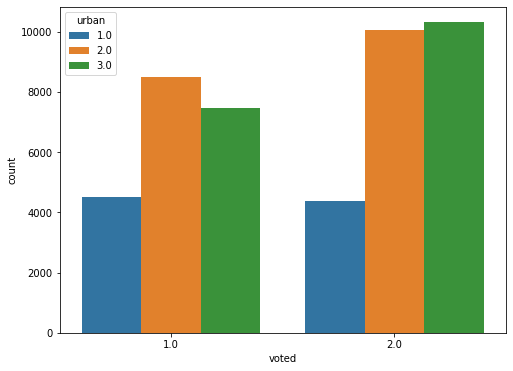

In [463]:
f, axes = plt.subplots(ncols=1 ,figsize =(8,6))

# sns.boxplot(x = 'voted', y = 'age_group',data = train, ax = axes[0])
sns.countplot(data=train,x="voted",hue="urban",ax=axes)
# axes[0,0].set_title('QaA')

<AxesSubplot:xlabel='voted', ylabel='count'>

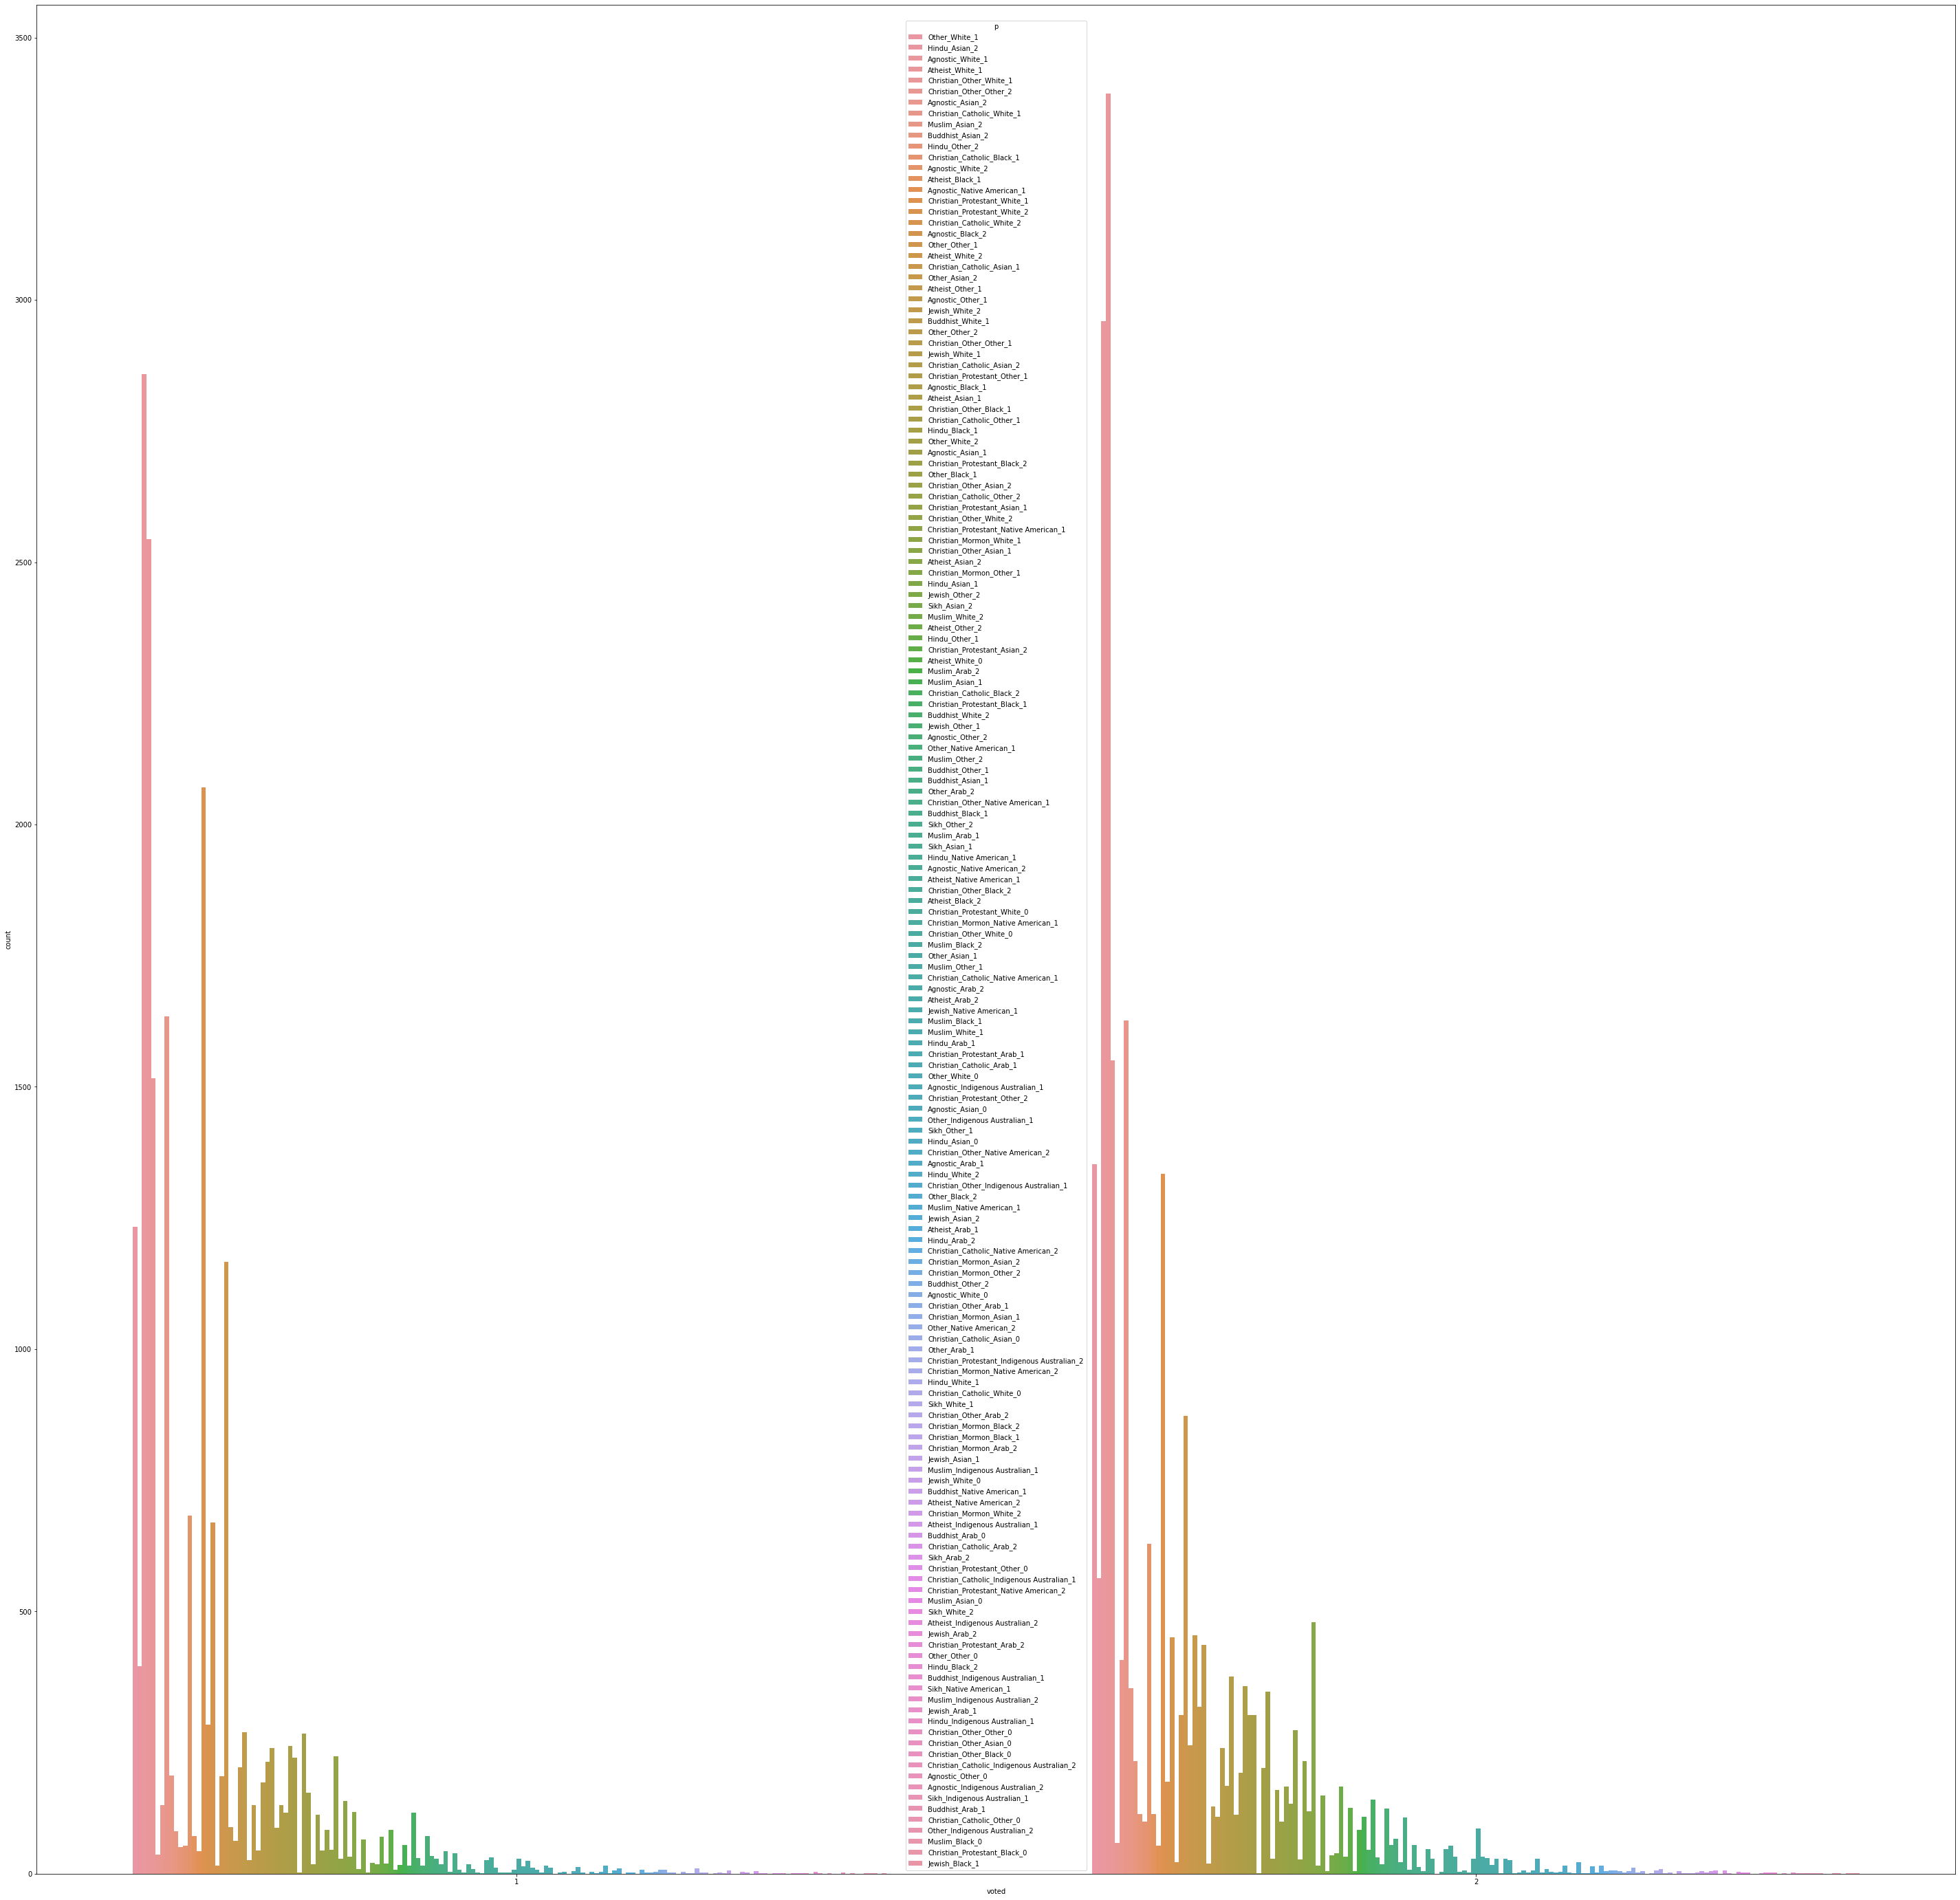

In [455]:
f, axes = plt.subplots(ncols=1 ,figsize =(50,50))

# sns.boxplot(x = 'voted', y = 'age_group',data = train, ax = axes[0])
sns.countplot(data=train,x="voted",hue="p",ax=axes)
# axes[0,0].set_title('QaA')

<AxesSubplot:xlabel='voted', ylabel='count'>

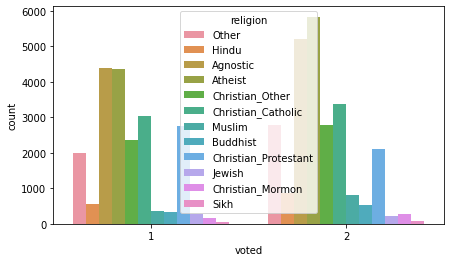

In [450]:
f, axes = plt.subplots(ncols=1 ,figsize =(7,4))

# sns.boxplot(x = 'voted', y = 'age_group',data = train, ax = axes[0])
sns.countplot(data=train,x="voted",hue="religion",ax=axes)
# axes[0,0].set_title('QaA')

<AxesSubplot:xlabel='voted', ylabel='count'>

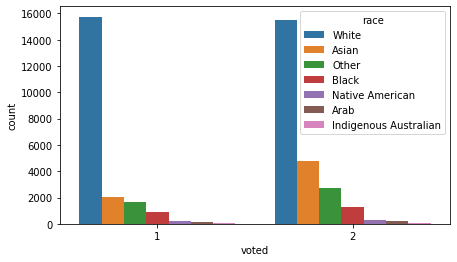

In [449]:
f, axes = plt.subplots(ncols=1 ,figsize =(7,4))

# sns.boxplot(x = 'voted', y = 'age_group',data = train, ax = axes[0])
sns.countplot(data=train,x="voted",hue="race",ax=axes)
# axes[0,0].set_title('QaA')

<AxesSubplot:xlabel='voted', ylabel='count'>

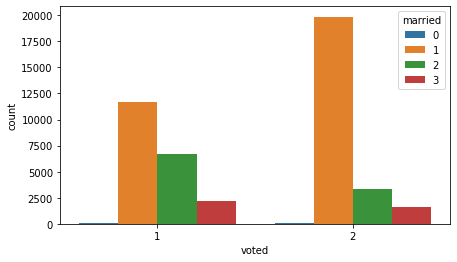

In [448]:
f, axes = plt.subplots(ncols=1 ,figsize =(7,4))

# sns.boxplot(x = 'voted', y = 'age_group',data = train, ax = axes[0])
sns.countplot(data=train,x="voted",hue="married",ax=axes)
# axes[0,0].set_title('QaA')

<AxesSubplot:xlabel='voted', ylabel='count'>

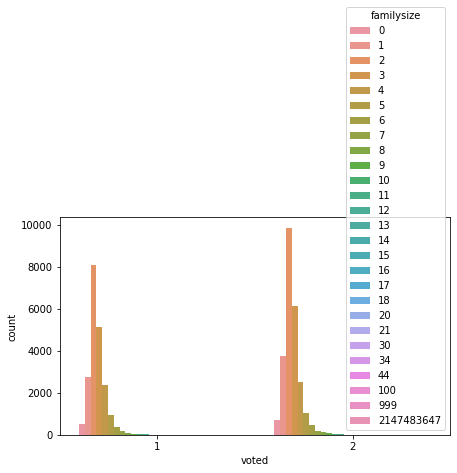

In [343]:
f, axes = plt.subplots(ncols=1 ,figsize =(7,4))

# sns.boxplot(x = 'voted', y = 'age_group',data = train, ax = axes[0])
sns.countplot(data=train,x="voted",hue="familysize",ax=axes)
# axes[0,0].set_title('QaA')

<AxesSubplot:xlabel='voted', ylabel='count'>

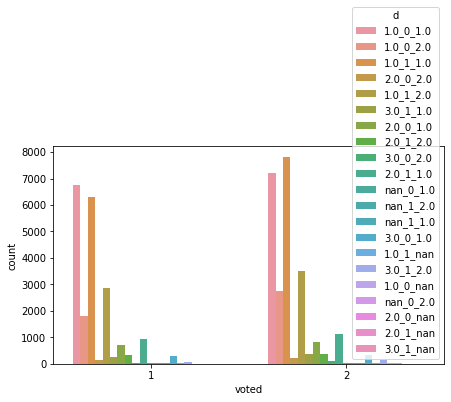

In [342]:
f, axes = plt.subplots(ncols=1 ,figsize =(7,4))

# sns.boxplot(x = 'voted', y = 'age_group',data = train, ax = axes[0])
sns.countplot(data=train,x="voted",hue="d",ax=axes)
# axes[0,0].set_title('QaA')

<AxesSubplot:xlabel='voted', ylabel='count'>

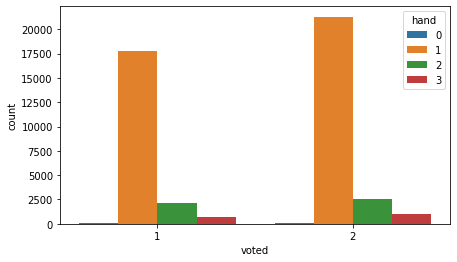

In [340]:
f, axes = plt.subplots(ncols=1 ,figsize =(7,4))

# sns.boxplot(x = 'voted', y = 'age_group',data = train, ax = axes[0])
sns.countplot(data=train,x="voted",hue="hand",ax=axes)
# axes[0,0].set_title('QaA')

<AxesSubplot:xlabel='voted', ylabel='count'>

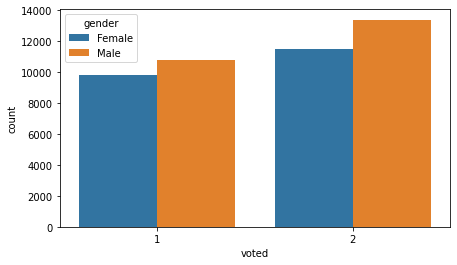

In [338]:
f, axes = plt.subplots(ncols=1 ,figsize =(7,4))

# sns.boxplot(x = 'voted', y = 'age_group',data = train, ax = axes[0])
sns.countplot(data=train,x="voted",hue="gender",ax=axes)
# axes[0,0].set_title('QaA')

<AxesSubplot:xlabel='voted', ylabel='count'>

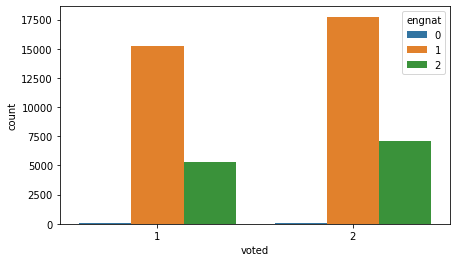

In [335]:
f, axes = plt.subplots(ncols=1 ,figsize =(7,4))

# sns.boxplot(x = 'voted', y = 'age_group',data = train, ax = axes[0])
sns.countplot(data=train,x="voted",hue="engnat",ax=axes)
# axes[0,0].set_title('QaA')

<AxesSubplot:xlabel='voted', ylabel='count'>

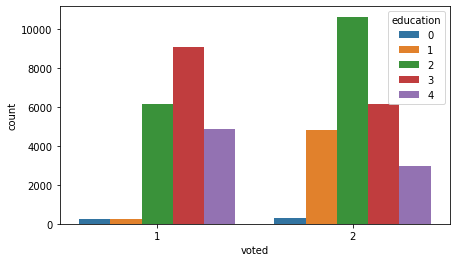

In [336]:
f, axes = plt.subplots(ncols=1 ,figsize =(7,4))

# sns.boxplot(x = 'voted', y = 'age_group',data = train, ax = axes[0])
sns.countplot(data=train,x="voted",hue="education",ax=axes)
# axes[0,0].set_title('QaA')

<AxesSubplot:xlabel='voted', ylabel='count'>

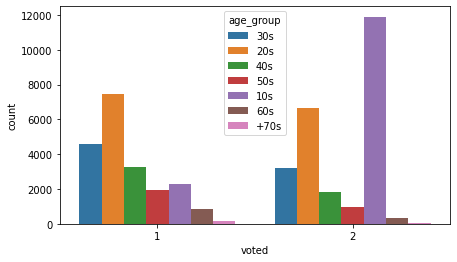

In [337]:
f, axes = plt.subplots(ncols=1 ,figsize =(7,4))

# sns.boxplot(x = 'voted', y = 'age_group',data = train, ax = axes[0])
sns.countplot(data=train,x="voted",hue="age_group",ax=axes)
# axes[0,0].set_title('QaA')

Text(0.5, 1.0, 'QtA')

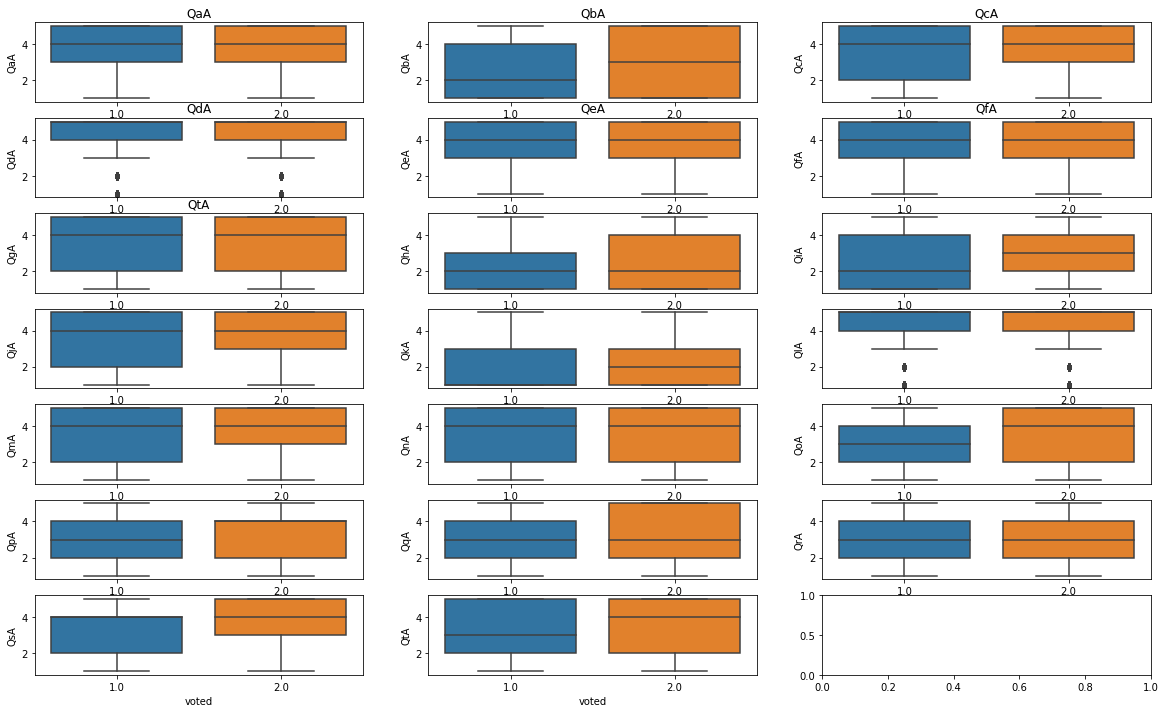

In [213]:
f, axes = plt.subplots(nrows=7, ncols=3 ,figsize =(20,12))

sns.boxplot(x = 'voted', y = 'QaA',data = train, ax = axes[0,0])
axes[0,0].set_title('QaA')
sns.boxplot(x = 'voted', y = 'QbA',data = train, ax = axes[0,1])
axes[0,1].set_title('QbA')
sns.boxplot(x = 'voted', y = 'QcA',data = train, ax = axes[0,2])
axes[0,2].set_title('QcA')
sns.boxplot(x = 'voted', y = 'QdA',data = train, ax = axes[1,0])
axes[1,0].set_title('QdA')
sns.boxplot(x = 'voted', y = 'QeA',data = train, ax = axes[1,1])
axes[1,1].set_title('QeA')
sns.boxplot(x = 'voted', y = 'QfA',data = train, ax = axes[1,2])
axes[1,2].set_title('QfA')
sns.boxplot(x = 'voted', y = 'QgA',data = train, ax = axes[2,0])
axes[2,0].set_title('QgA')
sns.boxplot(x = 'voted', y = 'QhA',data = train, ax = axes[2,1])
axes[2,0].set_title('QhA')
sns.boxplot(x = 'voted', y = 'QiA',data = train, ax = axes[2,2])
axes[2,0].set_title('QiA')
sns.boxplot(x = 'voted', y = 'QjA',data = train, ax = axes[3,0])
axes[2,0].set_title('QjA')
sns.boxplot(x = 'voted', y = 'QkA',data = train, ax = axes[3,1])
axes[2,0].set_title('QkA')
sns.boxplot(x = 'voted', y = 'QlA',data = train, ax = axes[3,2])
axes[2,0].set_title('QlA')
sns.boxplot(x = 'voted', y = 'QmA',data = train, ax = axes[4,0])
axes[2,0].set_title('QmA')
sns.boxplot(x = 'voted', y = 'QnA',data = train, ax = axes[4,1])
axes[2,0].set_title('QnA')
sns.boxplot(x = 'voted', y = 'QoA',data = train, ax = axes[4,2])
axes[2,0].set_title('QoA')
sns.boxplot(x = 'voted', y = 'QpA',data = train, ax = axes[5,0])
axes[2,0].set_title('QpA')
sns.boxplot(x = 'voted', y = 'QqA',data = train, ax = axes[5,1])
axes[2,0].set_title('QqA')
sns.boxplot(x = 'voted', y = 'QrA',data = train, ax = axes[5,2])
axes[2,0].set_title('QrA')
sns.boxplot(x = 'voted', y = 'QsA',data = train, ax = axes[6,0])
axes[2,0].set_title('QsA')
sns.boxplot(x = 'voted', y = 'QtA',data = train, ax = axes[6,1])
axes[2,0].set_title('QtA')


In [111]:
# col_list = []
# score_list = []
# from tqdm import tqdm_notebook
# com_l = ['wf_03', 'wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06', 'wr_07','wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13']
# for i in tqdm_notebook(range(len(com_l)-1)):
#     for j in range(i+1,len(com_l)):
#         print("sssssssssssssssssssssssssssssssssssssssssssss")
#         str1 = com_l[i]
#         str2 = com_l[j]
# #         all_df[str1+str2] = all_df[str1].apply(str) + '_' + all_df[str2].apply(str)
        
#         all_df[str1+str2] = all_df[str1] + all_df[str2]
#         for col in all_df.columns:
#             if all_df[col].dtype == 'object':
#                 le = LabelEncoder()
#                 all_df[col] = le.fit_transform(all_df[col])
#         train = all_df.iloc[:len(train),:]
#         test = all_df.iloc[len(train):,:]
#         X = train.drop(['voted'],1)
#         y = train['voted']
#         predictions = np.zeros(len(y))
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = SEED)
#         Lgb = lgb.LGBMClassifier( 
#                          silent=False, 
#                          random_state =10, 
#                          max_depth=15,
#                          num_leaves=500,
#                          learning_rate = 0.15,
#                          objective='binary',
#                          metrics ='auc',
#                          seed = SEED)
#         model = Lgb.fit(X_train, y_train)
#         predictions = model.predict(X_test)
#         proba = model.predict_proba(X_test)
#         score = roc_auc_score(y_test, predictions)
#         col_list.append(str1+str2)
#         score_list.append(score)
#         print('add',str1+'_'+str2," : ",score)
#         print("eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee")
#         del(all_df[str1+str2])

In [339]:
append_list = []
for i in range(len(score_list)):
    if score_list[i] > 0.6930514040919914:
        print(col_list[i])
        append_list.append(col_list[i])

wf_03wr_04
wr_07wr_10


In [334]:
append_list

['wf_03wr_04', 'wr_07wr_10']

In [349]:
del(all_df['wf_07wr_10'])

In [53]:
# all_df['wf_07wr_10'] = all_df['wr_07'] + all_df['wr_10']

In [391]:
for i in ['QaA', 'QaE', 'QbA', 'QbE', 'QcA', 'QcE', 'QdA', 'QdE', 'QeA', 'QeE',
       'QfA', 'QfE', 'QgA', 'QgE', 'QhA', 'QhE', 'QiA', 'QiE', 'QjA', 'QjE',
       'QkA', 'QkE', 'QlA', 'QlE', 'QmA', 'QmE', 'QnA', 'QnE', 'QoA', 'QoE',
       'QpA', 'QpE', 'QqA', 'QqE', 'QrA', 'QrE', 'QsA', 'QsE', 'QtA', 'QtE']:
    print(i)
    print(all_df[i].value_counts())

QaA
5.0    22860
4.0    16069
3.0     8958
2.0     6210
1.0     2818
Name: QaA, dtype: int64
QaE
5.899897     146
5.918894     145
6.061457     143
5.937536     141
6.021023     134
5.905362     133
5.886104     130
6.056784     127
5.826000     127
5.866468     126
6.234411     125
5.976351     123
5.986452     123
6.182085     123
6.186209     122
5.958425     122
5.924256     122
6.028279     122
5.872118     121
6.033086     121
6.011267     120
5.968708     119
5.950643     118
5.932245     118
5.955837     118
5.831882     118
5.891644     118
6.210600     117
5.913503     117
6.120297     116
6.142037     116
5.981414     115
6.037871     115
6.040255     115
6.066108     115
5.973810     114
6.084499     114
6.068426     114
6.079933     114
6.192362     113
6.146329     113
5.846439     113
6.093570     113
5.961005     113
6.045005     113
6.018593     113
6.098074     113
5.983936     113
5.736572     112
6.220590     112
6.131226     112
6.126869     111
5.940171     111
6.

QfA
5.0    24463
4.0    15904
2.0     6181
1.0     5740
3.0     4627
Name: QfA, dtype: int64
QfE
6.104793     105
6.040255     102
6.161207     101
6.224558     101
6.333280     100
6.349139      98
6.073045      98
6.276643      96
6.306275      95
6.459904      93
6.297109      93
6.257668      92
6.230481      92
6.270988      92
6.171701      92
6.455199      92
6.210600      92
6.429719      91
6.302619      91
6.100319      91
6.293419      91
6.238325      90
6.045005      90
6.315358      90
6.284134      90
6.028279      90
6.182085      90
6.142037      89
6.357842      89
6.289716      88
6.401917      88
6.390241      88
6.318968      87
6.177944      86
6.200509      86
6.249975      86
6.373320      86
6.261492      86
6.192362      86
5.993961      85
6.437752      85
6.413459      85
6.035481      85
6.077642      84
6.354370      84
6.444131      84
6.361302      84
6.033086      83
5.981414      83
6.150603      82
6.120297      82
6.327937      81
6.280396      81
6.

6.970730     67
6.975414     64
6.919684     61
6.756932     60
6.905753     60
6.844815     58
6.967909     57
6.863803     57
6.784457     57
6.941190     56
6.903747     56
6.748760     56
6.688355     56
6.952729     56
6.881411     55
6.734592     55
7.010312     55
6.837333     55
6.910751     54
7.190676     54
6.813445     54
6.947937     54
6.846943     53
6.751101     53
6.610696     53
6.959399     53
6.728629     53
7.033506     53
6.762730     53
6.920672     53
6.818924     52
6.862758     52
6.834109     52
6.821107     52
6.886532     52
6.999422     52
6.922644     52
6.648985     51
6.936343     51
6.889591     51
6.836259     51
6.872128     51
6.639876     51
6.983790     50
7.057898     50
6.856462     50
6.820016     50
6.838405     50
7.142827     50
7.131699     50
7.041412     50
6.548219     50
6.765039     49
6.809039     49
6.956545     49
7.141245     49
6.908755     49
6.759255     49
6.884487     49
6.859615     49
6.679599     49
6.871091     49
6.861711

Name: QpA, dtype: int64
QpE
6.673298     87
6.697034     83
6.530878     79
6.492240     77
6.639876     77
6.728629     76
6.381816     76
6.655440     75
6.598509     75
6.722630     75
6.579251     74
6.432940     72
6.630683     72
6.597146     72
6.413459     72
6.736967     71
6.786717     71
6.572283     70
6.558198     70
6.591674     70
6.792344     69
6.601230     69
6.685861     69
6.495266     69
6.756932     69
6.889591     69
6.548219     68
6.770789     68
6.740519     68
6.646391     68
6.708084     68
6.652863     68
6.473891     68
6.470800     68
6.675823     68
6.746412     68
6.535241     67
6.720220     67
6.706862     67
6.610696     67
6.679599     67
6.664409     67
6.800170     66
6.726233     66
6.762730     66
6.562444     65
6.624065     65
6.870053     65
6.648985     65
6.658011     65
6.773080     65
6.715383     65
6.682109     65
6.445720     64
6.466145     64
6.608001     64
6.796824     64
6.517671     64
6.393591     64
6.463029     64
6.410175    

In [92]:
all_df.columns

Index(['QaA', 'QaE', 'QbA', 'QbE', 'QcA', 'QcE', 'QdA', 'QdE', 'QeA', 'QeE',
       'QfA', 'QfE', 'QgA', 'QgE', 'QhA', 'QhE', 'QiA', 'QiE', 'QjA', 'QjE',
       'QkA', 'QkE', 'QlA', 'QlE', 'QmA', 'QmE', 'QnA', 'QnE', 'QoA', 'QoE',
       'QpA', 'QpE', 'QqA', 'QqE', 'QrA', 'QrE', 'QsA', 'QsE', 'QtA', 'QtE',
       'age_group', 'education', 'engnat', 'familysize', 'gender', 'hand',
       'married', 'race', 'religion', 'tp01', 'tp02', 'tp03', 'tp04', 'tp05',
       'tp06', 'tp07', 'tp08', 'tp09', 'tp10', 'urban', 'voted', 'wf_01',
       'wf_02', 'wf_03', 'wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06',
       'wr_07', 'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13',
       'Mach_score', 'wf_03wr_04'],
      dtype='object')

In [298]:
#TIPI = ['외향성','우호성','성실성','안정성','개방성']
# TIPI = ['Extraversion','Agreeableness','Conscientiousness','Neuroticism','Openness']
# all_df['Extraversion'] = all_df['tp01'] - all_df['tp06']
# all_df['Agreeableness'] = all_df['tp07'] - all_df['tp02']
# all_df['Conscientiousness'] = all_df['tp03'] - all_df['tp08']
# all_df['Neuroticism'] = all_df['tp09'] - all_df['tp04']
# all_df['Openness'] = all_df['tp05'] - all_df['tp10']
# all_df['+'] = all_df[['tp01','tp03','tp05','tp07','tp09']].sum(axis = 1)
# all_df['-'] = all_df[['tp02','tp04','tp06','tp08','tp10']].sum(axis = 1)

# for i in ('tp01','tp02','tp03','tp04','tp05','tp06','tp07','tp08','tp09','tp10'):
#     del(all_df[i])

In [369]:
all_df['wrsum'] = all_df[['wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06', 'wr_07', 'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13']].sum(axis = 1)

In [457]:
# df_model = df.copy()
from sklearn.preprocessing import LabelEncoder
for col in all_df.columns:
    if all_df[col].dtype == 'object':
        le = LabelEncoder()
        all_df[col] = le.fit_transform(all_df[col])
train = all_df.iloc[:len(train),:]
test = all_df.iloc[len(train):,:]

In [458]:
#테스트_트레인 셑 설정

from sklearn.model_selection import train_test_split
X = train.drop(['voted'],1)
y = train['voted']
predictions = np.zeros(len(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = SEED)


In [459]:
#모델 생성 및 학습
import lightgbm as lgb
Lgb = lgb.LGBMClassifier(
                         silent=False, 
                         random_state =10, 
                         max_depth=15,
                         num_leaves=500,
                         learning_rate = 0.15,
                         objective='binary',
                         metrics ='auc',
                         seed = SEED)
model = Lgb.fit(X_train, y_train)

[LightGBM] [Warning] seed is set=1996, random_state=10 will be ignored. Current value: seed=1996
[LightGBM] [Warning] seed is set=1996, random_state=10 will be ignored. Current value: seed=1996
[LightGBM] [Info] Number of positive: 19912, number of negative: 16508
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5622
[LightGBM] [Info] Number of data points in the train set: 36420, number of used features: 79
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546733 -> initscore=0.187477
[LightGBM] [Info] Start training from score 0.187477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [460]:
#test를 통한 모델 검증
predictions = model.predict(X_test)
proba = model.predict_proba(X_test)
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import f1_score, recall_score
score = roc_auc_score(y_test, predictions)
print('roc_auc_score마 스코어 + nan + log ++-:',score)

roc_auc_score마 스코어 + nan + log ++-: 0.6849814472286054


In [415]:
#test를 통한 모델 검증
predictions = model.predict(X_test)
proba = model.predict_proba(X_test)
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import f1_score, recall_score
score = roc_auc_score(y_test, predictions)
print('roc_auc_score마 스코어 + nan + log ++-:',score)

roc_auc_score마 스코어 + nan + log ++-: 0.6959140398295163


In [132]:
#test를 통한 모델 검증
predictions = model.predict(X_test)
proba = model.predict_proba(X_test)
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import f1_score, recall_score
score = roc_auc_score(y_test, predictions)
print('roc_auc_score마 스코어 + nan + log:',score)

roc_auc_score마 스코어 + nan + log: 0.6930514040919914


In [125]:
#test를 통한 모델 검증
predictions = model.predict(X_test)
proba = model.predict_proba(X_test)
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import f1_score, recall_score
score = roc_auc_score(y_test, predictions)
print('roc_auc_score마 스코어 + nan:',score)

roc_auc_score마 스코어 + nan: 0.6930514040919914


In [112]:
#test를 통한 모델 검증
predictions = model.predict(X_test)
proba = model.predict_proba(X_test)
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import f1_score, recall_score
score = roc_auc_score(y_test, predictions)
print('roc_auc_score마 스코어:',score)

roc_auc_score마 스코어: 0.6915771517984072


In [101]:
#test를 통한 모델 검증
predictions = model.predict(X_test)
proba = model.predict_proba(X_test)
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import f1_score, recall_score
score = roc_auc_score(y_test, predictions)
print('roc_auc_score 기본:',score)

roc_auc_score 기본: 0.6869799312231405


In [64]:
SEED = 1996
NUM_BOOST_ROUND = 50000

#######################
### FOR Stratified ####
N_SPLITS = 5
lgbm_param = {
    "objective": "binary",
    'n_estimators' : 3000,
    "boosting": "gbdt",
    "num_leaves": 40,
    "learning_rate": 0.008,
    "feature_fraction": 0.9,
    "reg_lambda": 2,
#     "metric": "binary",
    "num_class" : 3,
    'seed' : SEED,
}

예측치를 구해주고

In [88]:
pred_y = model.predict(test)

In [89]:
pred_y

array([1., 2., 2., ..., 1., 1., 2.])

In [90]:
submission['voted']=pred_y

제출!!

In [92]:
submission.to_csv('sample_submission2.csv')